## 1. Geopolitical Dependency Analysis
To understand the supply chain risk, we first analyze the origin of imports. The goal is to visualize the dominance of specific geopolitical and regional blocs.

In [41]:
# --- 1. ENVIRONMENT SETUP ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Create output directory
if not os.path.exists('img'):
    os.makedirs('img')

# Visual Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# --- 2. GOVERNANCE FUNCTIONS ---
def format_currency(value):
    """Formats financial values to Billions (B) or Millions (M)."""
    if value >= 1e9:
        return f'${value / 1e9:.2f}B'
    return f'${value / 1e6:.2f}M'

def shorten_description(text, max_len=35):
    """Truncates long descriptions for cleaner plots."""
    text = str(text)
    if len(text) <= max_len: return text
    return text[:max_len] + '...'

def fix_encoding_issues(text):
    """Fix common encoding artifacts (Mojibake) like 'VietnÃ£' -> 'Vietnã'."""
    if not isinstance(text, str): return text
    try:
        return text.encode('latin1').decode('utf-8')
    except:
        return text

# --- 3. DATA INGESTION (ETL) ---
csv_file = 'H_IMPORTACAO_GERAL_2025-01_2025-12_DT20251126.CSV'

# Robust Loading Strategy: Try UTF-8 FIRST (Standard), then fallback to Latin1
try:
    try:
        df = pd.read_csv(csv_file, sep=';', encoding='utf-8')
        print("✅ Data loaded (UTF-8).")
    except:
        df = pd.read_csv(csv_file, sep=';', encoding='latin1')
        print("⚠️ Data loaded (Latin1) - Applying encoding fixers...")

    # Standardizing Schema - Renaming 'country' to 'actor'
    df.columns = ['ncm', 'description', 'actor', 'exp_value', 'exp_kg', 'imp_value', 'imp_kg']

    # --- 4. DATA CLEANING & TRANSLATION ---
    # 4.1 Clean Whitespace & Fix Encoding Artifacts
    df['actor'] = df['actor'].astype(str).str.strip().apply(fix_encoding_issues)

    # 4.2 Translation Dictionary (PT-BR -> EN)
    country_map = {
        'China': 'China',
        'Taiwan (Formosa)': 'Taiwan',
        'Taiwan': 'Taiwan', # Safe redundancy
        'Estados Unidos': 'United States',
        'Coreia do Sul': 'South Korea',
        'Vietnã': 'Vietnam',
        'Vietna': 'Vietnam', # Safe redundancy
        'Japão': 'Japan',
        'Japao': 'Japan',
        'Malásia': 'Malaysia',
        'Singapura': 'Singapore',
        'Hong Kong': 'Hong Kong',
        'Alemanha': 'Germany',
        'Holanda': 'Netherlands',
        'Países Baixos': 'Netherlands',
        'França': 'France',
        'Itália': 'Italy',
        'Reino Unido': 'United Kingdom',
        'Suíça': 'Switzerland',
        'Tailândia': 'Thailand',
        'Filipinas': 'Philippines',
        'Índia': 'India',
        'México': 'Mexico',
        'Israel': 'Israel'
    }

    # 4.3 Apply Translation
    df['actor'] = df['actor'].map(country_map).fillna(df['actor'])

    # --- 5. STRATEGIC CALCULATION ENGINE ---
    # Financial KPIs
    total_imp = df['imp_value'].sum()
    total_exp = df['exp_value'].sum()
    trade_balance = total_exp - total_imp
    import_export_ratio = total_imp / total_exp if total_exp > 0 else 0

    # Geopolitical Risk (Asian Block Definition - English Keys)
    asian_block_keywords = ['China', 'Taiwan', 'South Korea', 'Vietnam', 'Malaysia', 'Japan', 'Singapore', 'Hong Kong', 'Thailand', 'Philippines']

    # Case-insensitive search on translated column
    asia_mask = df['actor'].str.contains('|'.join(asian_block_keywords), case=False, regex=True, na=False)

    total_imp_asia = df[asia_mask]['imp_value'].sum()
    asia_share = (total_imp_asia / total_imp) * 100

    # Top Players
    top_suppliers = df.groupby('actor')['imp_value'].sum().sort_values(ascending=False).head(5)

    # Executive Log (Validation)
    print("✅ DATA PIPELINE COMPLETE.")
    print(f"► Dependency Ratio: {import_export_ratio:.1f}x")
    print(f"► Asian Exposure:   {asia_share:.2f}%")
    print("► Top Countries (Translated Check):")
    print(top_suppliers.index.tolist())
except Exception as e:
    print(f"❌ CRITICAL ERROR: {e}")


⚠️ Data loaded (Latin1) - Applying encoding fixers...
✅ DATA PIPELINE COMPLETE.
► Dependency Ratio: 85.3x
► Asian Exposure:   95.64%
► Top Countries (Translated Check):
['China', 'South Korea', 'Taiwan', 'Vietnam', 'Malaysia']


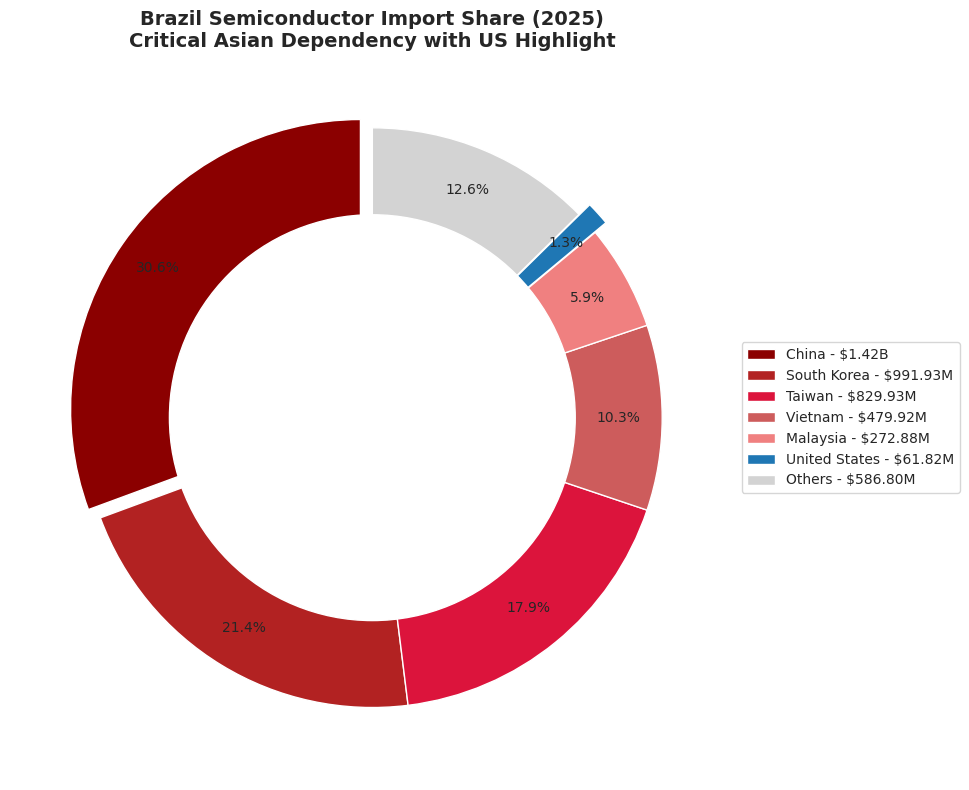

In [42]:
# --- Market Share Analysis (Donut Chart) ---
if 'df' in locals():
    df_country = df.groupby('actor')['imp_value'].sum().sort_values(ascending=False)

    # Extract United States value separately
    us_value = df_country.get('United States', 0)

    # Create a temporary series excluding United States for top-N calculation
    df_country_no_us = df_country.drop('United States', errors='ignore')

    # Get top N countries (e.g., top 5) excluding the United States
    top_n = 5
    top_countries_for_plot = df_country_no_us.head(top_n)

    # Calculate 'Others' value from remaining countries after top_n and United States are removed
    others_value = df_country_no_us.iloc[top_n:].sum()

    # Combine data for plotting. Only add US if it has import value.
    plot_data_list = [top_countries_for_plot]
    if us_value > 0:
        plot_data_list.append(pd.Series({'United States': us_value}))
    plot_data_list.append(pd.Series({'Others': others_value}))

    plot_data = pd.concat(plot_data_list)

    # Strategic Red Palette to highlight concentration for top countries
    # Add a distinct color for United States and a neutral one for Others
    colors = ['#8b0000', '#b22222', '#dc143c', '#cd5c5c', '#f08080'] # For top 5 (mostly Asian)
    if us_value > 0:
        colors.append('#1f77b4') # Distinct blue for United States
    colors.append('#d3d3d3') # Grey for Others

    # Adjust explode list dynamically
    explode = [0] * len(plot_data) # Initialize all to 0
    if len(plot_data) > 0:
        explode[0] = 0.05 # Explode the largest slice (China)
    if 'United States' in plot_data.index:
        us_index = plot_data.index.get_loc('United States')
        explode[us_index] = 0.05 # Explode United States slice

    plt.figure(figsize=(10, 8))
    plt.pie(plot_data, labels=None, autopct='%1.1f%%', startangle=90, colors=colors, pctdistance=0.85, explode=explode)
    plt.gca().add_artist(plt.Circle((0,0), 0.70, fc='white'))

    plt.title('Brazil Semiconductor Import Share (2025)\nCritical Asian Dependency with US Highlight', fontsize=14, weight='bold')
    legend_labels = [f"{idx} - {format_currency(val)}" for idx, val in zip(plot_data.index, plot_data.values)]
    plt.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

    # Save artifact
    plt.savefig('img/grafico_pizza_share_chips.png', dpi=150)
    plt.show()


## 2. Top Suppliers & Geopolitical Risk
A deep dive into the top 10 suppliers exposes the "Asian Chip Triangle" (China, Taiwan, South Korea). Red bars indicate high geopolitical risk origins, while blue bars represent Western or diversified sources.

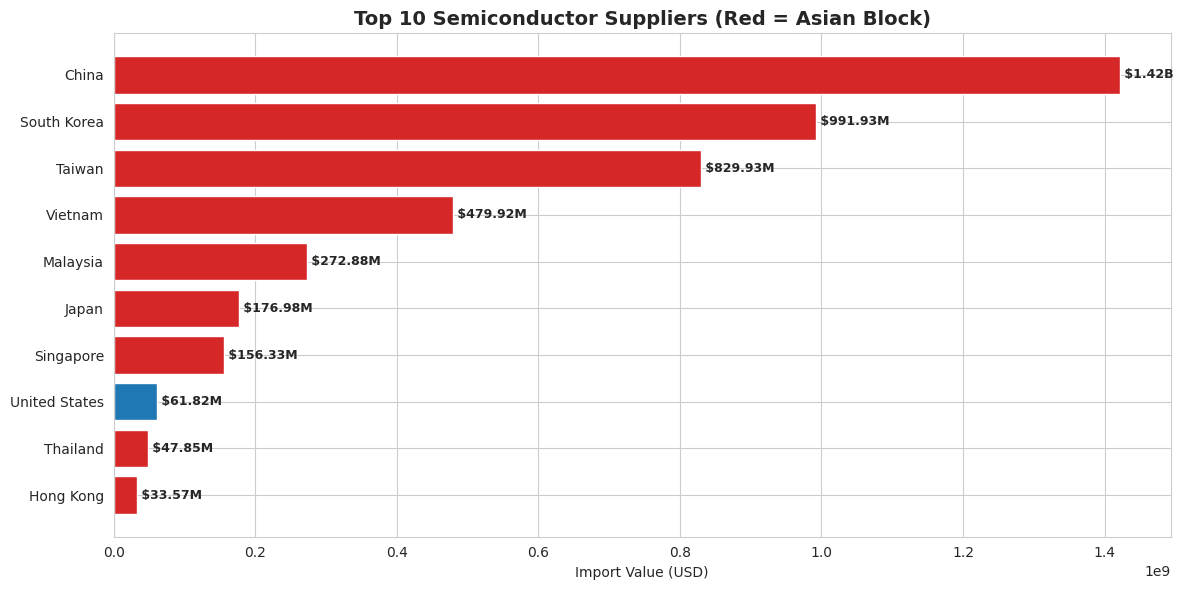

In [43]:
if 'df' in locals():
    top_10 = df_country.head(10).sort_values(ascending=True)

    # Risk Coloring: Red for Asia, Blue for Others
    bar_colors = ['#d62728' if any(x in str(c) for x in asian_block_keywords) else '#1f77b4' for c in top_10.index]

    plt.figure(figsize=(12, 6))
    bars = plt.barh(top_10.index, top_10.values, color=bar_colors)
    plt.title('Top 10 Semiconductor Suppliers (Red = Asian Block)', fontsize=14, weight='bold')
    plt.xlabel('Import Value (USD)')

    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2, f' {format_currency(width)}', va='center', fontsize=9, weight='bold')

    plt.tight_layout()
    plt.savefig('img/analise_dependencia_chips.png', dpi=150)
    plt.show()


## 3. Technology Density: Value vs. Volume
By analyzing the **Price per Kg**, we distinguish high-tech processors from low-end components.
* **High Value / Low Volume:** Advanced Technology (Taiwan's focus).
* **Low to Medium Value / High Volume:** Commodities and assembly components (China's mass market).

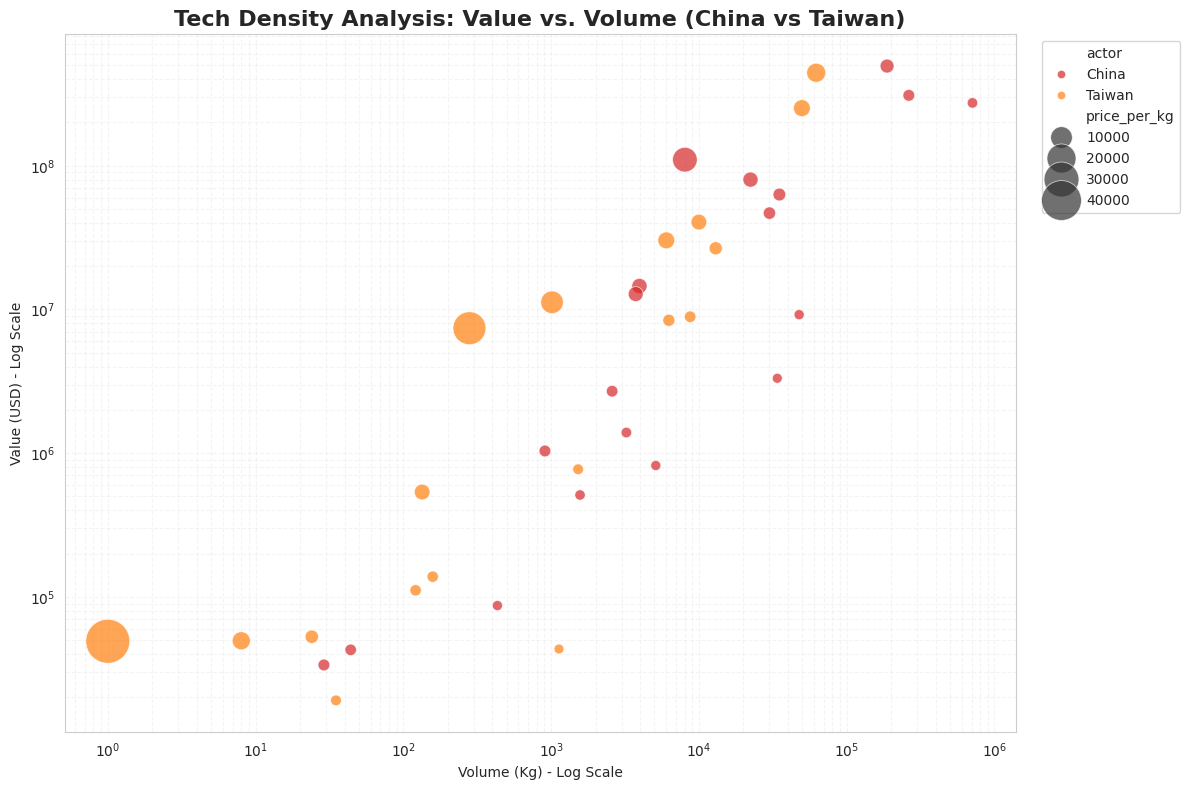

In [44]:
if 'df' in locals():
    # Drill down to Product Level
    drill = df.groupby(['actor', 'ncm', 'description']).agg({'imp_value': 'sum', 'imp_kg': 'sum'}).reset_index()
    drill['price_per_kg'] = drill['imp_value'] / drill['imp_kg']

    # Direct Comparison: China vs Taiwan
    drill_targets = drill[drill['actor'].str.contains('China|Taiwan', case=False, regex=True, na=False)]
    drill_targets = drill_targets[drill_targets['imp_value'] > 10000] # Remove noise

    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=drill_targets, x='imp_kg', y='imp_value', hue='actor', size='price_per_kg',
        sizes=(50, 1000), alpha=0.7, palette={'China': '#d62728', 'Taiwan': '#ff7f0e'}
    )
    plt.xscale('log'); plt.yscale('log')
    plt.title('Tech Density Analysis: Value vs. Volume (China vs Taiwan)', fontsize=16, weight='bold')
    plt.xlabel('Volume (Kg) - Log Scale'); plt.ylabel('Value (USD) - Log Scale')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(True, which="both", ls="--", alpha=0.2)

    plt.tight_layout()
    plt.savefig('img/scatter_preco_volume_tech.png', dpi=150)
    plt.show()


## 4. Trade Balance & Sovereignty
The final KPI illustrates the massive financial disparity. The ratio between Imports and Exports confirms a lack of domestic technological sovereignty, creating a severe dependency on external supply chains.

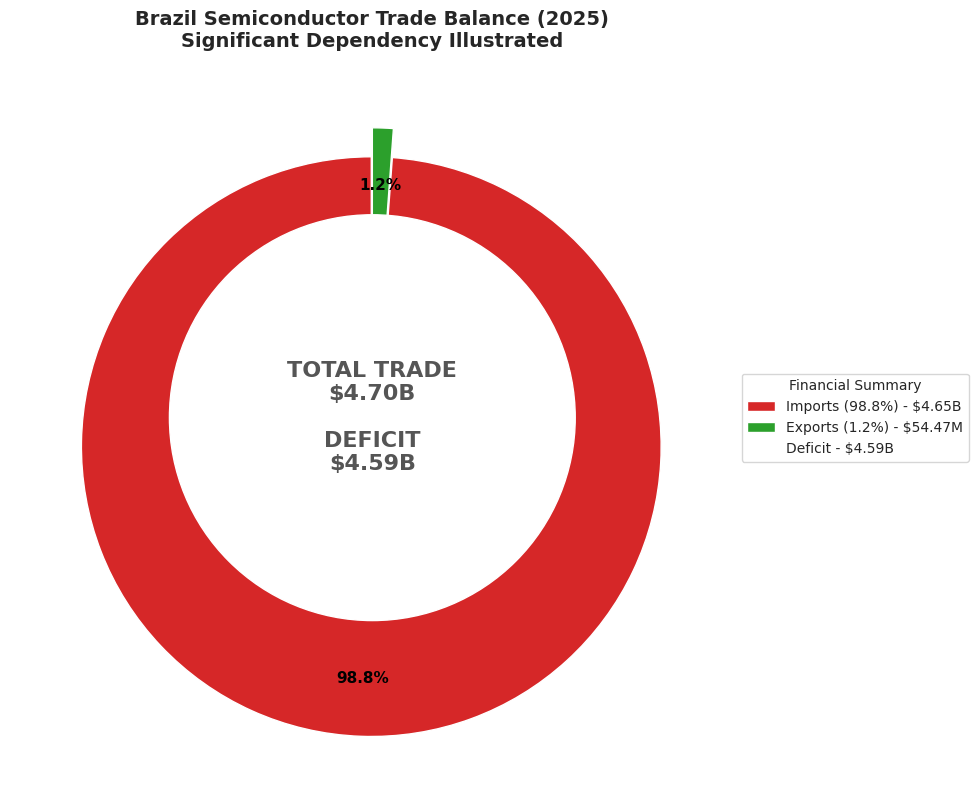

In [45]:
if 'df' in locals():
    # Financial Data
    balance_values = [total_imp, total_exp]
    deficit_value = abs(total_exp - total_imp)
    total_trade_volume = total_imp + total_exp # Calculate total trade volume

    # Custom Label Logic for autopct
    def make_autopct_with_labels(values, labels):
        def my_autopct(pct):
            total = sum(values)
            val = pct * total / 100.0
            # Return only percentage for the chart wedges, full label goes to legend
            return f'{pct:.1f}%'
        return my_autopct

    fig, ax = plt.subplots(figsize=(10, 8))

    # Plotting
    labels = ['Imports', 'Exports']
    wedges, texts, autotexts = ax.pie(
        balance_values, autopct=make_autopct_with_labels(balance_values, labels), startangle=90,
        colors=['#d62728', '#2ca02c'], explode=(0.1, 0), pctdistance=0.8,
        textprops={'fontsize': 11, 'color': 'black', 'weight': 'bold'}
    )

    # Draw a circle in the center to make it a donut chart
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    fig.gca().add_artist(centre_circle)

    # Display Total Trade and Deficit in the center of the donut chart
    ax.text(0, 0,
            f'TOTAL TRADE\n{format_currency(total_trade_volume)}\n\nDEFICIT\n{format_currency(deficit_value)}',
            ha='center', va='center',
            fontsize=16, color='#555555', weight='bold')

    # Legend with explicit Imports/Exports and Deficit
    legend_labels = [
        f"Imports ({balance_values[0]/sum(balance_values)*100:.1f}%) - {format_currency(total_imp)}",
        f"Exports ({balance_values[1]/sum(balance_values)*100:.1f}%) - {format_currency(total_exp)}",
        f"Deficit - {format_currency(deficit_value)}"
    ]
    ax.legend(legend_labels, loc="center left", bbox_to_anchor=(1, 0.5), title="Financial Summary")
    ax.set_title('Brazil Semiconductor Trade Balance (2025)\nSignificant Dependency Illustrated', fontsize=14, weight='bold')

    plt.tight_layout()
    plt.savefig('img/balanca_comercial_semicondutores.png', dpi=150)
    plt.show()
